In [5]:
import pennylane as qml
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

dev = qml.device("default.qubit", wires=1)
def circuit(params, wires=0):
    qml.RX(params[0], wires=wires)
    qml.RY(params[1], wires=wires)
coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]
H = qml.Hamiltonian(coeffs, obs)
cost_fn = qml.ExpvalCost(circuit, H, dev)

eta = 0.01
init_params = np.array([0.011, 0.012])
opt = qml.QNGOptimizer(eta)
theta_new = opt.step(cost_fn, init_params)
print(theta_new)

[ 0.01144524 -0.02751952]


C:\Users\haime\AppData\Roaming\Python\Python37\site-packages\pennylane\_grad.py:204: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  UserWarning,
C:\Users\haime\AppData\Roaming\Python\Python37\site-packages\pennylane\_grad.py:100: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  UserWarning,


6.410757253368615
1.4319750469207175
-3.5680249530792825
-6.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825
-7.5680249530792825


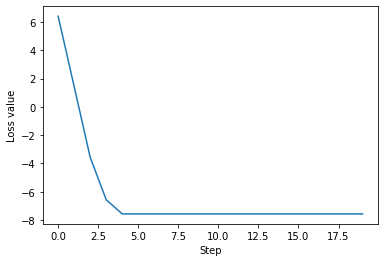

In [8]:
import numpy as np
import qtm.base_qtm
import matplotlib.pyplot as plt


def f(thetas):
    return thetas[0] ** 2 + 10*np.sin(thetas[1] - 4)


# derivative of objective function
def df(thetas):
    return np.asarray([2*thetas[0], 10*np.cos(thetas[1] - 4)])


thetas = np.array([5, 10])
loss = []
for k in range(0, 10):
    for i in range(0, thetas.shape[0]):
        if i == 0:
            m = list(np.zeros(thetas.shape[0]))
            v = list(np.zeros(thetas.shape[0]))
        thetas = qtm.base_qtm.adam(thetas, m, v, k, df(thetas))
        
        loss.append(f(thetas))
        print(f(thetas))

plt.plot(loss)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.show()
